In [1306]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from shap import TreeExplainer, summary_plot
import shap
shap.initjs()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Recall

import warnings
warnings.filterwarnings('ignore')

# Business understanding

Despite the fact that phishing is an ancient and a very straightforward attack, phishing attacks accounted for 36% of all US data breaches in 2023. 94% of firms are hit by phishing attacks in 2023. A lot of companies and organizations still perform phishing simulation exercises with employees today. Therefore, there is a need to create an engine that would correctly identify phishing (malicious) url as such and vice versa.

## The Business Objective

There are **two business** objectives for this project:  
1.The first objective is to build a machine learning model what would correctly classify an url into two classes: a) normal url b) phishing url. An url can belong to only one class.   
2. The model should be realatively light so it could be deployed locally on the target machines as well. 

The model would be available for security vendors who would like to add or improve phishing detecting capabilities.

# Data Understanding

## Data description

Data was acquired through the publicly available lists of phishing and legitimate websites by Grega Vrbančič and others, from which the features presented in the datasets were extracted by the authors. They published the details of data collection [here](https://www.sciencedirect.com/science/article/pii/S2352340920313202) and published the datasets on Github [here](https://github.com/GregaVrbancic/Phishing-Dataset).

In [1144]:
df = pd.read_csv('https://raw.githubusercontent.com/GregaVrbancic/Phishing-Dataset/master/dataset_full.csv')

The original full dataset has 88647 samples and 112 features. However, it was decided to use 20,000 samples for the capstone. (Please refer to the for the additional research on how the sample size impacts the model performance.)

In [1146]:
#Using pandas.DataFrame.sample to sample 20,000 samples
df2 = df.sample(n=20000, random_state=42)
df2.shape

(20000, 112)

In [1148]:
df2.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
29026,4,0,0,0,0,0,0,0,0,0,...,1,3,1,3598,0,-1,0,0,0,0
52848,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3598,1,0,0,0,0,0
3821,2,0,0,0,0,0,0,0,0,0,...,2,2,0,299,1,0,0,0,0,0
74221,4,0,0,0,0,0,0,0,0,0,...,1,3,3,3585,0,0,0,0,0,0
34258,2,0,0,0,0,0,0,0,0,0,...,-1,8,1,-1,0,-1,0,0,0,0


In [1150]:
#moderately imbalanced dataset
df2.phishing.value_counts(normalize=True)

0    0.6548
1    0.3452
Name: phishing, dtype: float64

## Data Cleaning and Pre-processing

The original data is relatively clean. It also doesn't contain categorical variables.

In [1153]:
#no categorical values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 29026 to 56070
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 17.2 MB


In [1155]:
#no missing values
assert df2.isna().agg('sum').sum() == 0

In [1157]:
#checking for dulplicate rows
df2.duplicated().sum()

184

In [1159]:
#dropping duplicate rows
df2 = df2.drop_duplicates(keep=False)

In [1161]:
#verifying that there are no more duplicates rows
assert df2.duplicated().sum() == 0

In [1163]:
df2.shape

(19720, 112)

## Exploratory Data Analysis (EDA)

Due to the nature of the data and the business problem, there isn't much EDA that can be performed for this dataset. There are no business value in understanding relationships between number of question marks and number of backslashs in the data, for example. I'm providing this assessment as a certified (CISSP) domain expert with 10+ experience in cybersecurity. 

With that said, it's clear that all 112 features are not required to build a model. As in a car, for example, not all car features and mechanisms have any impact on the maximum speed. Not all features of an url have any impact on the url being malicious or not.

### Variance in dataset sections

The entire dataset was devided into the following sections:
- Dataset attributes based on URL
- Dataset attributes based on Domain URL
- Dataset attributes based on URL directory
- Dataset attributes based on URL file name
- Dataset attributes based on URL parameters
- Dataset attributes based on resolving URL and external services

So it makes sense to check how these sections might be different.

Let's devide the data in the section and compare different characteristics, like variance.

In [1167]:
df2_copy = df2.copy()

In [1169]:
#Let's create a separate dataframe for each section
df_url = df2_copy.iloc[:, :19].assign(email_in_url=df2_copy['email_in_url'])
df_domain = df2_copy.iloc[:, 19:40]
df_directory = df2_copy.iloc[:, 40:58]
df_file = df2_copy.iloc[:, 58:76]
df_param = df2_copy.iloc[:, 76:96]
df_external = df2_copy.iloc[:, 97:111]

In [1171]:
#We will exclude the last section from comparision becuase it contains data of a different kind (external to an url)
dataframes = [df_url, df_domain, df_directory, df_file, df_param]
df_names = ['URL', 'Domain', 'Directory', 'File', 'Parameter']

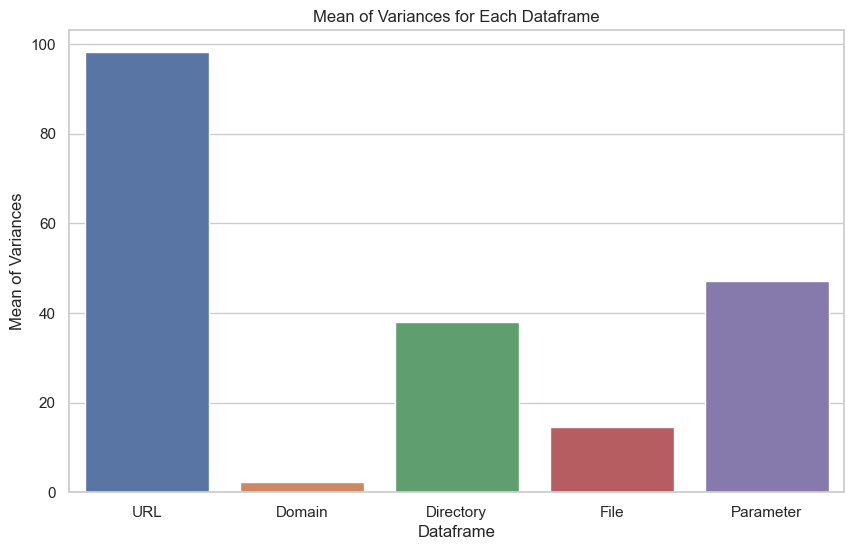

In [1291]:
#Let's calculate mean values of variances for all sections and plot the result
results_var = []
for df2_copy, name in zip(dataframes, df_names):
    result = df2_copy.var().mean()
    results_var.append({'Dataframe': name, 'Variance Mean': result})
result_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataframe', y='Variance Mean', data=result_df)
plt.title('Mean of Variances for Each Dataframe')
plt.xlabel('Dataframe')
plt.ylabel('Mean of Variances')
plt.show()

As we can see, the domain section has near zero mean variance which might indicate its less importance.

## Multicollinearity

The dataset has as high degree of multicollinearity which will be proven in the following code by counting feature pairs that has a high correlation (>0.8). As we discussed previously (on zoom), we will not do anything to reduce multicollinearity upfront, and I have this code for reference and/or completeness.

In [1175]:
corr_matrix = df2.corr()
threshold = 0.8
#Create a mask to ignore self-correlations (diagonal) and lower triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
#Extract pairs of features with correlation greater than the threshold
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                   for i, j in zip(*np.where((np.abs(corr_matrix) > threshold) & mask))]

In [1177]:
len(high_corr_pairs)

495

# Data preparation and removing constant features

In [1179]:
#Creating train and test data
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(labels=['phishing'], axis=1),
    df2['phishing'],
    test_size=0.2,
    random_state=0)

As we discussed previous, reducing number of features is one of the business objectives. The first method we will use to do so is sklearn.feature_selection.VarianceThreshold.

In [1181]:
#we will create a function that will find features with a set threshold and will return transformed dataset and selected features.
def variance_threshold_selector(X_train, X_test, threshold=0):
    sel = VarianceThreshold(threshold=threshold)
    sel.fit(X_train)
    constant = X_train.columns[~sel.get_support()]
    print(len(constant))
    feat_names = X_train.columns[sel.get_support()]
    X_train_transformed = sel.transform(X_train)
    X_test_transformed = sel.transform(X_test)
    return X_train_transformed, X_test_transformed, feat_names

In [1183]:
X_train_transformed, X_test_transformed, selected_features = variance_threshold_selector(X_train, X_test, 0)

14


In [1185]:
#VarianceThreshold feature selector found 14 features with 0 variance and we removed them from the dataset.
X_train_transformed.shape, X_test_transformed.shape

((15776, 97), (3944, 97))

We can check how many features from domain section was selected by this feature selector

In [1187]:
selected_featurest_list = selected_features.astype(str).tolist()
# Count occurrences of "_domain" in the Index
count = sum("_domain" in item for item in selected_featurest_list)
print(count)

7


In [1189]:
#Only 7 out of 25 which correlates with our previous analysis.

## Scaling

In [1191]:
#standard scaling
scaler = StandardScaler()

scaler.fit(X_train_transformed)

X_train_scaled = scaler.transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

## PCA

PCA is another method we will use to reduce number of features

In [1193]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [1195]:
# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 36


# Aplying models

**Models are scored differently on different hardware, i.e., exactly the same notebook run on different machines might produce different scores. The difference is tiny, but it technically impacts what model is best performing. Most of the capstone was done on my main Macbook, Google Colab and AWS SageMaker. All three environments had RandomForrest as a winner. Just two days before the deadline, my main Macbook started to have technical issues, so I switched to a different Macbook which had XGBoost as a winner. However, it was too late to change anything, so treated I RandomForrest as a winner. However, as you can see they both are very close**

## About accuracy metric

For this dataset, a false positive will be observed when a model labels a normal site as malicious. A false negative will be observed when a model labels a malicious site as normal. False negatives are more dangerous as a user will trust a malicious site. Therefore, we will be using recall score and ROC AUC as a secondary score.

Function to run and evaluate models

In [1198]:
def run_model(model, X_train, X_test, return_scores=True):

    model.fit(X_train, y_train)

    metrics = {
        "recall": recall_score,
        "auc_roc": roc_auc_score
    }

    scores = {}
    for name, metric in metrics.items():
        scores[f"{name}_test"] = metric(y_test, model.predict(X_test))
        scores[f"{name}_train"] = metric(y_train, model.predict(X_train))


    #for key, score in scores.items():
        #print(f"{key.replace('_', ' ').title()}: {round(score, 3)}")

    # Compute and print confusion matrices
    print("\nConfusion Matrix (Test):")
    print(confusion_matrix(y_test, model.predict(X_test)))

    if return_scores:
        return scores

Function to create a dataframe with the evaluation results

In [1200]:
def create_evaluation_dataframe(models, X_train, X_test):
    data = {
        'Model': [],
        'Recall': [],
        'AUC': []
    }

    for name, model in models.items():
        print()
        print(f"Evaluating model: {name}")
        scores = run_model(model, X_train, X_test, return_scores=True)
        data['Model'].append(name)
        data['Recall'].append(scores['recall_test'])
        data['AUC'].append(scores['auc_roc_test'])

    df = pd.DataFrame(data)
    return df

Function to plot model performance

In [1202]:
def plot_model_performance(df, data_name='Data'):
    # Melt the DataFrame to long format
    df_melted = df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

    # Create the grouped bar plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)

    # Customize the plot
    plt.title(f'Model Performance Comparison ({data_name})', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.legend(title='Metric')

    # the size of x and y ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add value labels on the bars
    for i in plt.gca().containers:
        plt.gca().bar_label(i, fmt='%.3f', label_type='center')

    plt.tight_layout()
    plt.show()

Function to calculate differences between runs

In [1204]:
def calculate_percentage_difference(df1, df2, suffix1='', suffix2=''):
    # Merge DataFrames on 'Model'
    df_merged = pd.merge(df1, df2, on='Model', suffixes=(suffix1, suffix2))

    # Calculate the percentage difference
    df_merged['Recall_diff_%'] = ((df_merged['Recall' + suffix2] - df_merged['Recall' + suffix1]) / df_merged['Recall' + suffix1]) * 100
    df_merged['AUC_diff_%'] = ((df_merged['AUC' + suffix2] - df_merged['AUC' + suffix1]) / df_merged['AUC' + suffix1]) * 100

    return df_merged

Function to plot differences

In [1088]:
def plot_percentage_differences(df, data_names=''):
    # Melt the DataFrame to make it suitable for seaborn
    df_melted = df.melt(id_vars='Model', value_vars=['Recall_diff_%', 'AUC_diff_%'], 
                        var_name='Metric', value_name='Percentage Difference')

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Percentage Difference', hue='Metric', data=df_melted)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Percentage Difference in Recall and AUC ({data_names})')
    plt.xlabel('Model')
    plt.ylabel('Percentage Difference')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

In [1206]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    #"SVM": SVC(probability=True),  # SVM perform badly on this dataset and takes a lot of time
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=0),
    "XGBoost": xgb.XGBClassifier(seed=123)

}

## Dummy classifier

In [1208]:
dummy_clf = DummyClassifier(strategy="prior").fit(X_train_scaled, y_train)

for dataset, X, y in [("Test", X_test_scaled, y_test), ("Train", X_train_scaled, y_train)]:
    preds = dummy_clf.predict(X)
    print(f"{dataset} set recall score: {recall_score(y, preds):.3f}")
    print(f"{dataset} set ROC AUC score: {roc_auc_score(y, preds):.3f}")

Test set recall score: 0.000
Test set ROC AUC score: 0.500
Train set recall score: 0.000
Train set ROC AUC score: 0.500


In [76]:
#0.5 indicates random guessing

In [1210]:
y_pred_test_dummy = dummy_clf.predict(X_test_scaled)

In [1212]:
#the dummy classifer predicts no instance of 1 class, therefore we can't really calculate false negative rate or
#recall score
np.unique(y_pred_test_dummy)

array([0])

## Running models with the default data

In [1214]:
X_train_scaled.shape

(15776, 97)

In [1216]:
df_default = create_evaluation_dataframe(models, X_train_scaled, X_test_scaled)


Evaluating model: Logistic Regression

Confusion Matrix (Test):
[[2422  162]
 [ 118 1242]]

Evaluating model: Decision Tree

Confusion Matrix (Test):
[[2447  137]
 [ 124 1236]]

Evaluating model: KNN

Confusion Matrix (Test):
[[2452  132]
 [  99 1261]]

Evaluating model: Random Forest

Confusion Matrix (Test):
[[2498   86]
 [  61 1299]]

Evaluating model: XGBoost

Confusion Matrix (Test):
[[2503   81]
 [  59 1301]]


In [1218]:
#Resulting table for models with the default data
df_default

,Model,Recall,AUC
0,Logistic Regression,0.913235,0.925271
1,Decision Tree,0.908824,0.927902
2,KNN,0.927206,0.938061
3,Random Forest,0.955147,0.960933
4,XGBoost,0.956618,0.962635


Both XGBoost and Random Forest show pretty much similar results

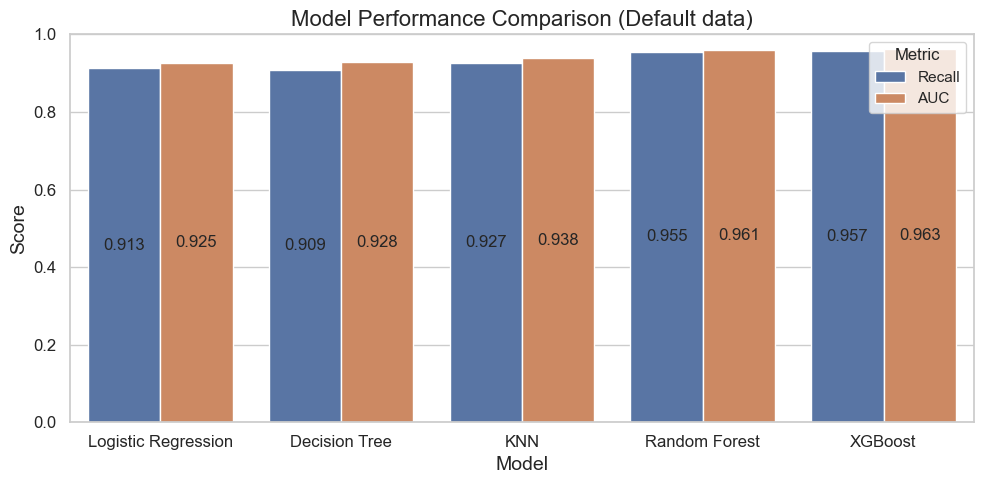

In [1293]:
#Let's plot the results
plot_model_performance(df_default, data_name="Default data")

## Running models with data prepared by PCA (36 components)

In [1222]:
df_pca = create_evaluation_dataframe(models, X_train_pca, X_test_pca)


Evaluating model: Logistic Regression

Confusion Matrix (Test):
[[2395  189]
 [ 112 1248]]

Evaluating model: Decision Tree

Confusion Matrix (Test):
[[2422  162]
 [ 142 1218]]

Evaluating model: KNN

Confusion Matrix (Test):
[[2454  130]
 [ 113 1247]]

Evaluating model: Random Forest

Confusion Matrix (Test):
[[2453  131]
 [  72 1288]]

Evaluating model: XGBoost

Confusion Matrix (Test):
[[2472  112]
 [  85 1275]]


In [1224]:
#Resulting table for models with the PCA data
df_pca

,Model,Recall,AUC
0,Logistic Regression,0.917647,0.922252
1,Decision Tree,0.895588,0.916447
2,KNN,0.916912,0.933301
3,Random Forest,0.947059,0.948181
4,XGBoost,0.937500,0.947078


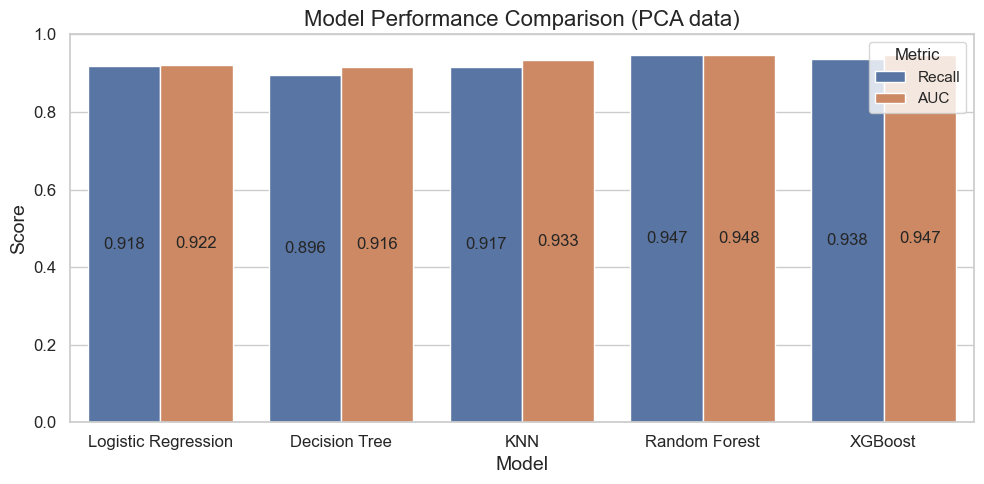

In [1295]:
plot_model_performance(df_pca, data_name="PCA data")

### Calculating difference between models with default data vs. PCA data

In [1235]:
calculate_percentage_difference(df_default, df_pca, suffix1='_default', suffix2='_pca')

,Model,Recall_default,AUC_default,Recall_pca,AUC_pca,Recall_diff_%,AUC_diff_%
0,Logistic Regression,0.913235,0.925271,0.917647,0.922252,0.483092,-0.326237
1,Decision Tree,0.908824,0.927902,0.895588,0.916447,-1.456311,-1.234516
2,KNN,0.927206,0.938061,0.916912,0.933301,-1.110230,-0.507436
3,Random Forest,0.955147,0.960933,0.947059,0.948181,-0.846805,-1.326997
4,XGBoost,0.956618,0.962635,0.937500,0.947078,-1.998463,-1.616113


As we can see, except for recall score for logistic regression, every other metric degraded.

## Recursive feature elimination

I used Recursive feature elimination to find number of features that would achieve the best recall score. The number of features was 46, please refer to the Appendix for more details on using recursive feature elimination.

In [1259]:
rfe1 = RFE(RandomForestClassifier(n_estimators=300, random_state=0), n_features_to_select=46)

In [1261]:
rfe1.fit(X_train_scaled, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=300, random_state=0),
    n_features_to_select=46)

In [1263]:
#restoring dataframe
X_train_scaled = pd.DataFrame(X_train_transformed, columns=selected_features)
X_test_scaled = pd.DataFrame(X_test_transformed, columns=selected_features)

In [1265]:
selected_feat = X_train_scaled.columns[(rfe1.get_support())]
len(selected_feat)

46

In [1267]:
X_train_selected = X_train_scaled[selected_feat]
X_test_selected = X_test_scaled[selected_feat]

X_train_selected.shape, X_test_selected.shape

((15776, 46), (3944, 46))

## Running models with 46 features

In [1269]:
df_rfe46 = create_evaluation_dataframe(models, X_train_selected, X_test_selected)


Evaluating model: Logistic Regression

Confusion Matrix (Test):
[[2351  233]
 [ 106 1254]]

Evaluating model: Decision Tree

Confusion Matrix (Test):
[[2455  129]
 [ 119 1241]]

Evaluating model: KNN

Confusion Matrix (Test):
[[2294  290]
 [ 350 1010]]

Evaluating model: Random Forest

Confusion Matrix (Test):
[[2496   88]
 [  57 1303]]

Evaluating model: XGBoost

Confusion Matrix (Test):
[[2501   83]
 [  69 1291]]


In [1330]:
#Resulting table for models with the 46 features
df_rfe46

,Model,Recall,AUC
0,Logistic Regression,0.922059,0.915944
1,Decision Tree,0.912500,0.931289
2,KNN,0.742647,0.815209
3,Random Forest,0.958088,0.962016
4,XGBoost,0.949265,0.958572


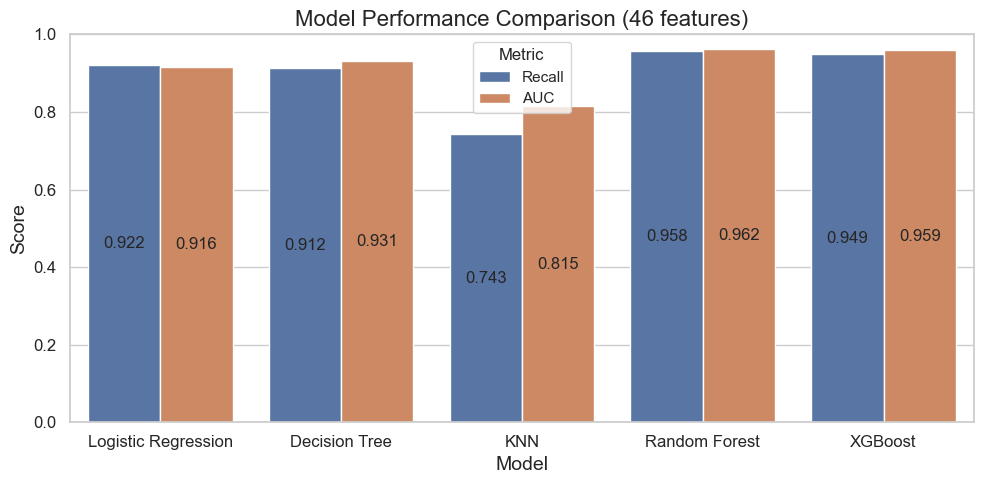

In [1297]:
plot_model_performance(df_rfe46, data_name='46 features')

### Calculating difference between models with default data vs. 46 features

In [1273]:
calculate_percentage_difference(df_default, df_rfe46, suffix1='_default', suffix2='_rfe46')

,Model,Recall_default,AUC_default,Recall_rfe46,AUC_rfe46,Recall_diff_%,AUC_diff_%
0,Logistic Regression,0.913235,0.925271,0.922059,0.915944,0.966184,-1.007989
1,Decision Tree,0.908824,0.927902,0.912500,0.931289,0.404531,0.364933
2,KNN,0.927206,0.938061,0.742647,0.815209,-19.904837,-13.096392
3,Random Forest,0.955147,0.960933,0.958088,0.962016,0.307929,0.112765
4,XGBoost,0.956618,0.962635,0.949265,0.958572,-0.768640,-0.422119


## Running models with 40 features selected by VarianceThreshold selector

In [1275]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    df2.drop(labels=['phishing'], axis=1),
    df2['phishing'],
    test_size=0.2,
    random_state=0)

In [1277]:
X_train_transformed2, X_test_transformed2, selected_features2 = variance_threshold_selector(X_train, X_test, 0.3)

71


In [1281]:
X_train_transformed2.shape

(15776, 40)

In [1283]:
df_vt03 = create_evaluation_dataframe(models, X_train_transformed2, X_test_transformed2)


Evaluating model: Logistic Regression

Confusion Matrix (Test):
[[2386  198]
 [ 149 1211]]

Evaluating model: Decision Tree

Confusion Matrix (Test):
[[2452  132]
 [ 123 1237]]

Evaluating model: KNN

Confusion Matrix (Test):
[[2290  294]
 [ 352 1008]]

Evaluating model: Random Forest

Confusion Matrix (Test):
[[2503   81]
 [  61 1299]]

Evaluating model: XGBoost

Confusion Matrix (Test):
[[2503   81]
 [  69 1291]]


In [1336]:
#Resulting table for models with the 40 features or 0.3 variance threshold
df_vt03

,Model,Recall,AUC
0,Logistic Regression,0.890441,0.906908
1,Decision Tree,0.909559,0.929238
2,KNN,0.741176,0.813700
3,Random Forest,0.955147,0.961900
4,XGBoost,0.949265,0.958959


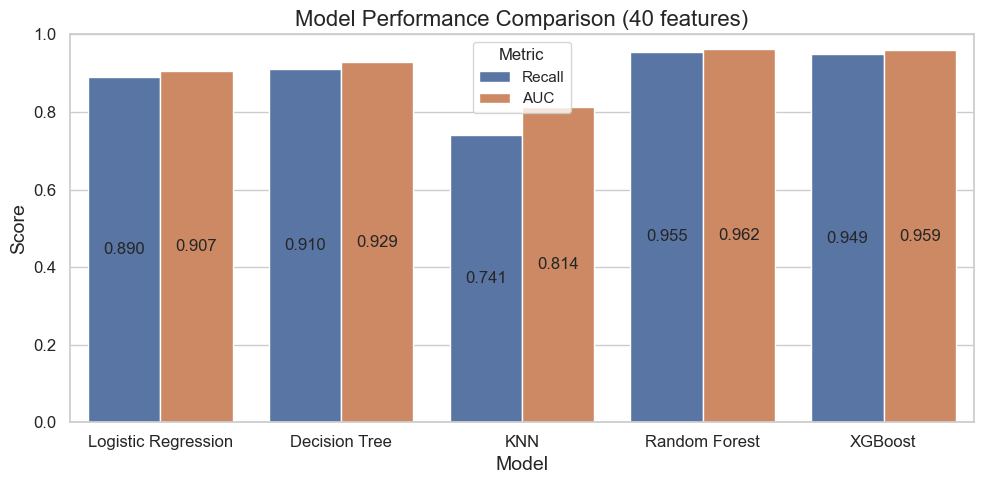

In [1299]:
plot_model_performance(df_vt03, data_name='40 features')

### Calculating difference between models with default data vs. 40 features or variance threshold 0.3

In [1287]:
calculate_percentage_difference(df_default, df_vt03, suffix1='_default', suffix2='_vt03')

,Model,Recall_default,AUC_default,Recall_vt03,AUC_vt03,Recall_diff_%,AUC_diff_%
0,Logistic Regression,0.913235,0.925271,0.890441,0.906908,-2.495974,-1.984608
1,Decision Tree,0.908824,0.927902,0.909559,0.929238,0.080906,0.143888
2,KNN,0.927206,0.938061,0.741176,0.813700,-20.063442,-13.257287
3,Random Forest,0.955147,0.960933,0.955147,0.961900,0.000000,0.100683
4,XGBoost,0.956618,0.962635,0.949265,0.958959,-0.768640,-0.381917


# Evaluation

## The impact of data size on the models scores

In [1028]:
dfs = [('Default', df_default), ('PCA', df_pca), ('RFE46', df_rfe46), ('VT03', df_vt03)]

# List of models
modelsd = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest', 'XGBoost']

# Function to create dataframe
def create_dataframe(metric):
    data = {'Data': [name for name, _ in dfs]}
    
    for model in modelsd:
        column_name = model.split()[0]
        data[column_name] = [df.loc[df['Model'] == model, metric].values[0] for _, df in dfs]
    
    return pd.DataFrame(data)

# Create dataframes for Recall and AUC
df_recall = create_dataframe('Recall')
df_auc = create_dataframe('AUC')

In [1030]:
df_recall

,Data,Logistic,Decision,KNN,Random,XGBoost
0,Default,0.913235,0.909559,0.927206,0.955147,0.956618
1,PCA,0.917647,0.894118,0.916912,0.947059,0.937500
2,RFE46,0.922059,0.913971,0.742647,0.958088,0.949265
3,VT03,0.890441,0.913971,0.741176,0.955147,0.949265


In [1032]:
df_auc

,Data,Logistic,Decision,KNN,Random,XGBoost
0,Default,0.925271,0.927496,0.938061,0.960933,0.962635
1,PCA,0.922252,0.913971,0.933301,0.948181,0.947078
2,RFE46,0.915944,0.933185,0.815209,0.962016,0.958572
3,VT03,0.906908,0.932604,0.813700,0.961900,0.958959


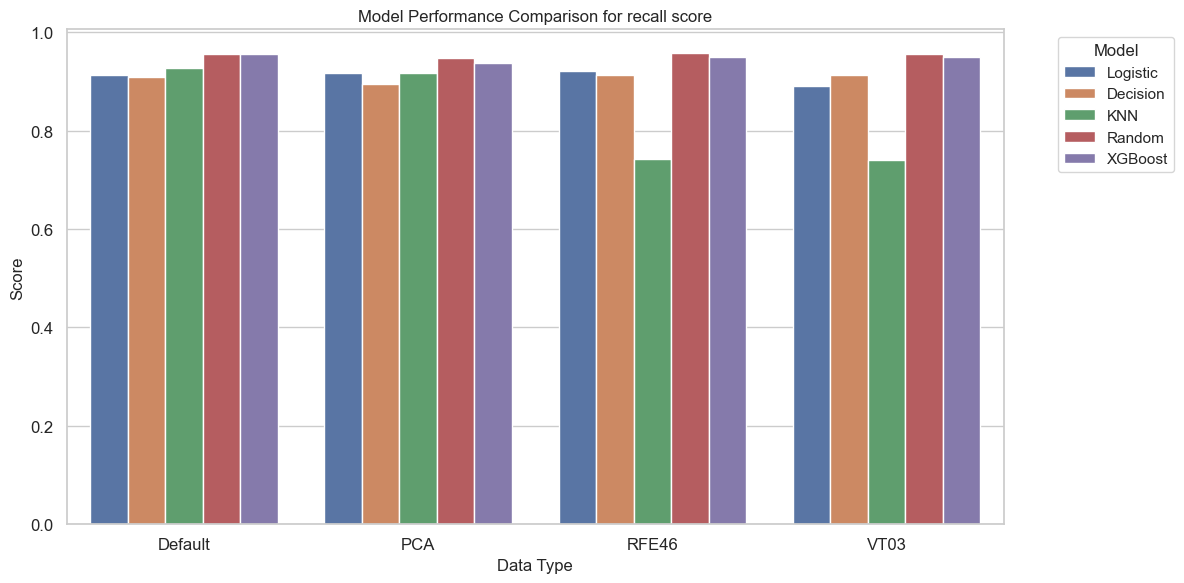

In [1302]:
# Melt the DataFrame to long format
df_melted1 = df_recall.melt(id_vars=['Data'], var_name='Model', value_name='Score')

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Data', y='Score', hue='Model', data=df_melted1)

# Customize the plot
plt.title('Model Performance Comparison for recall score')
plt.xlabel('Data Type')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# the size of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

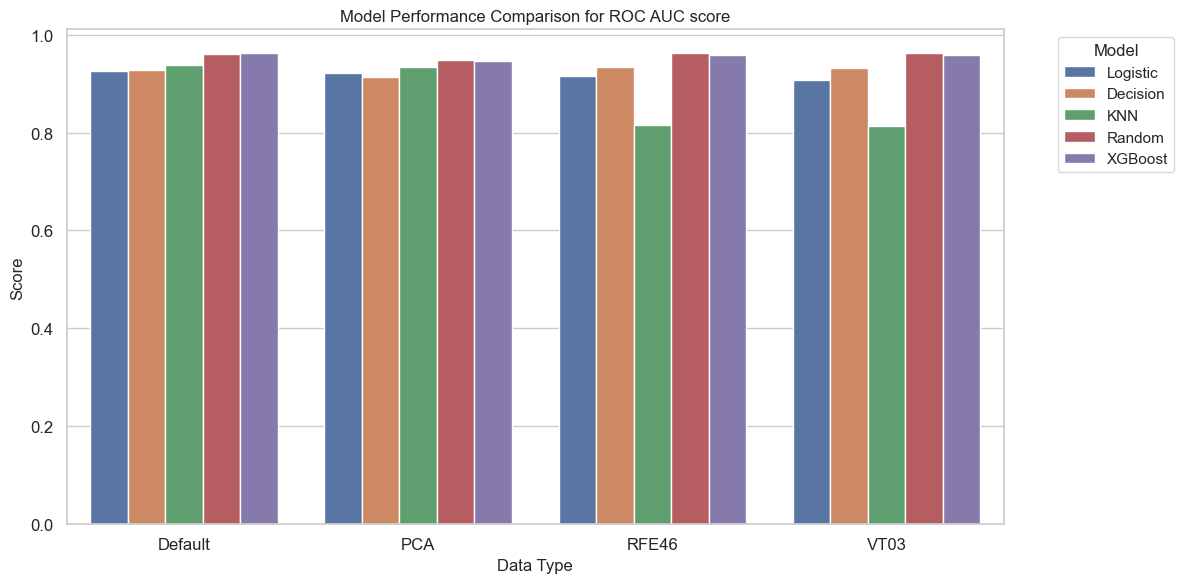

In [1304]:
# Melt the DataFrame to long format
df_melted2 = df_auc.melt(id_vars=['Data'], var_name='Model', value_name='Score')

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Data', y='Score', hue='Model', data=df_melted2)

# Customize the plot
plt.title('Model Performance Comparison for ROC AUC score')
plt.xlabel('Data Type')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# the size of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## ROC curve for the best model

In [1349]:
rforest1 = RandomForestClassifier(n_estimators=300,random_state=0).fit(X_train_selected, y_train)

In [1351]:
#Get the predicted probabilities for the positive class:
y_prob = rforest1.predict_proba(X_test_selected)[:, 1]

In [1353]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

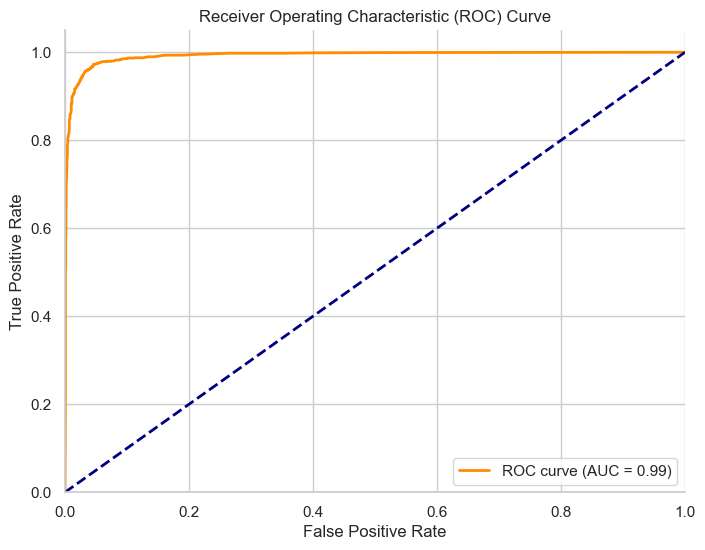

In [1355]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
sns.despine()
plt.show()

## SHAP Values for the best model

In [1357]:
explainer = shap.Explainer(rforest1, X_train_selected)

In [1359]:
shap_values = explainer(X_train_selected)

100%|===================| 31547/31552 [50:42<00:00]        

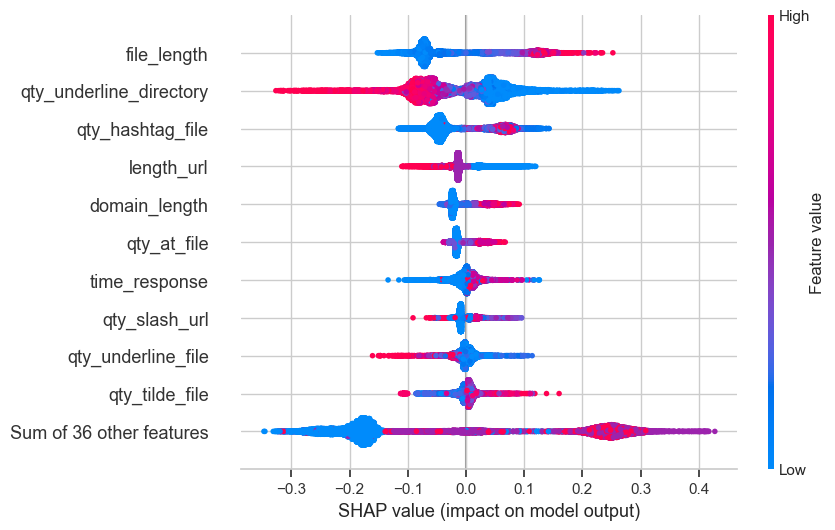

In [1441]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=11)

## Sklearn feature importances for the best model

In [111]:
feature_names = list(X_train_selected.columns)

In [115]:
# Get feature importances from the model
feature_importances = rforest1.feature_importances_

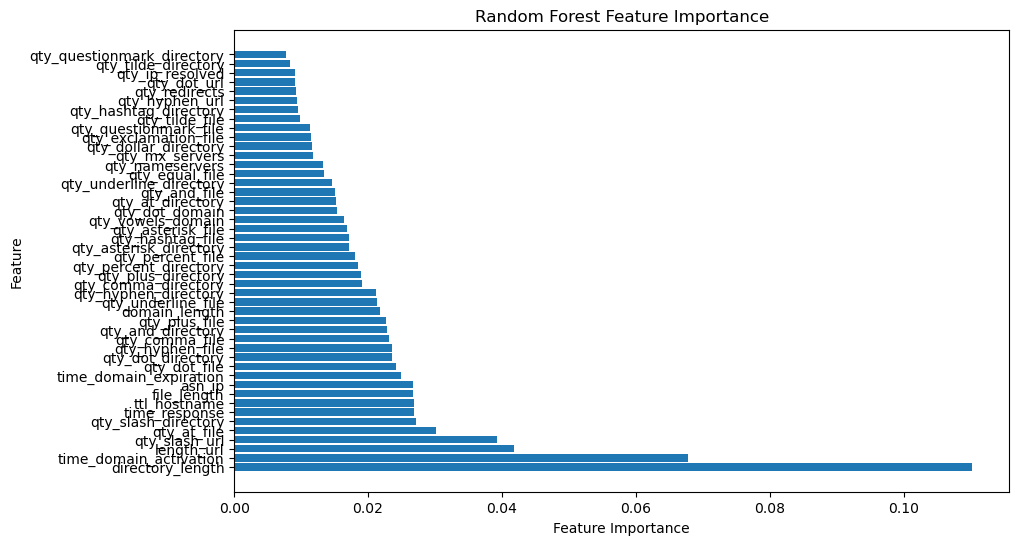

In [117]:
# Sort features and their importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [1343]:
#Table view

In [119]:
coeff_table2 = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Coefficient': sorted_feature_importances
})

In [121]:
coeff_table2.head(10)

,Feature,Coefficient
0,directory_length,0.110244
1,time_domain_activation,0.067850
2,length_url,0.041738
3,qty_slash_url,0.039322
4,qty_at_file,0.030106
5,qty_slash_directory,0.027209
6,time_response,0.026890
7,ttl_hostname,0.026846
8,file_length,0.026765
9,asn_ip,0.026688


## Feature imortances for the second best performing model*

*Can be the best model as we discuss above

In [99]:
xg = xgb.XGBClassifier(seed=123)

In [101]:
xg.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

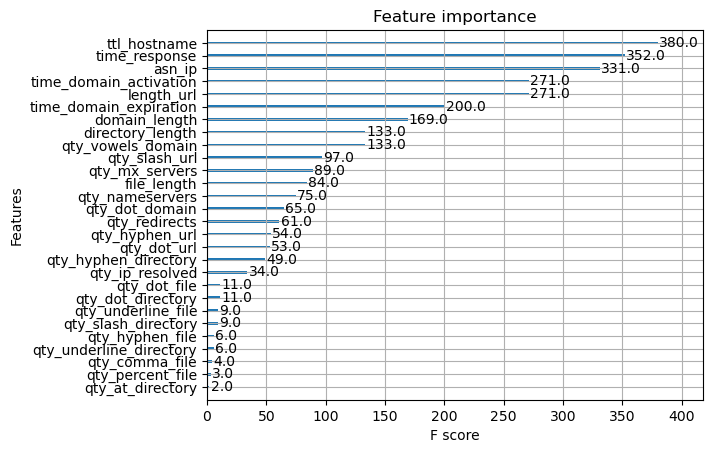

In [103]:
xgb.plot_importance(xg)
plt.show()

In [1345]:
#Table view

In [105]:
booster = xg.get_booster()
importance = booster.get_score(importance_type='weight')

In [107]:
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

In [109]:
importance_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
26,ttl_hostname,380.0
19,time_response,352.0
20,asn_ip,331.0
3,length_url,271.0
21,time_domain_activation,271.0
22,time_domain_expiration,200.0
6,domain_length,169.0
5,qty_vowels_domain,133.0
12,directory_length,133.0
2,qty_slash_url,97.0


## Feature importance overlap

length_url, qty_slash_url, time_response

Other top features: ttl_hostname, directory length

1) length_url (total number of characters in an url) has both negative and positive impact on predicting the target. From the shap plot, we can say that the longer url, the more chances that it is phishing which also intuitevely makes sense as well.
2) qty_slash_url (number of ”/” signs) has the same properties as length_url in terms of prediction, but has less power according to SHAP.
3) time_response (domain lookup time response) has both negative and positive impact on predicting the target. Longer time responses should increase possibility of an url being phishing.

## GridSearchCV

GridSearch didn't find parameters that would improve the model's performance.

In [149]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [151]:
recall_scorer = make_scorer(recall_score)

In [153]:
rf_grid = RandomForestClassifier(random_state=0)
grid_search_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid, scoring=recall_scorer, cv=5, n_jobs=-1, verbose=0)

In [155]:
grid_search_rf.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(recall_score))

In [157]:
best_params = grid_search_rf.best_params_
best_model = grid_search_rf.best_estimator_

In [159]:
print(f'Best Parameters: {best_params}')

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [161]:
y_pred_grid_test = best_model.predict(X_test_selected)
y_pred_grid_train = best_model.predict(X_train_selected)

In [163]:
recall_test_rf_grid = recall_score(y_test, y_pred_grid_test)
recall_train_rf_grid = recall_score(y_train, y_pred_grid_train)

In [165]:
print("Test set recall score: ", round(recall_test_rf_grid, 3))
print("Train set recall score: ", round(recall_train_rf_grid, 3))

Test set recall score:  0.954
Train set recall score:  0.99


<a name="appendix"></a>
# Appendix

## Neural networks

Neural networks were introduced to us after I already started the work on the capstone. As I much I tried learned it quickly, I still feel like I barely scratched the surface with them. Therefore, I used it once in the project and it didn't produce good enough scores, so I put in the Appendix.

In [185]:
# Creating the model
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [187]:
# Adding AUC and Recall metrics to model compilation
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Recall(name='recall')])

In [189]:
# Training the model
history = model_nn.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [191]:
#Evaluating the model
test_loss, test_accuracy, test_auc, test_recall = model_nn.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test accuracy: 0.9029
Test AUC: 0.9587
Test Recall: 0.9221


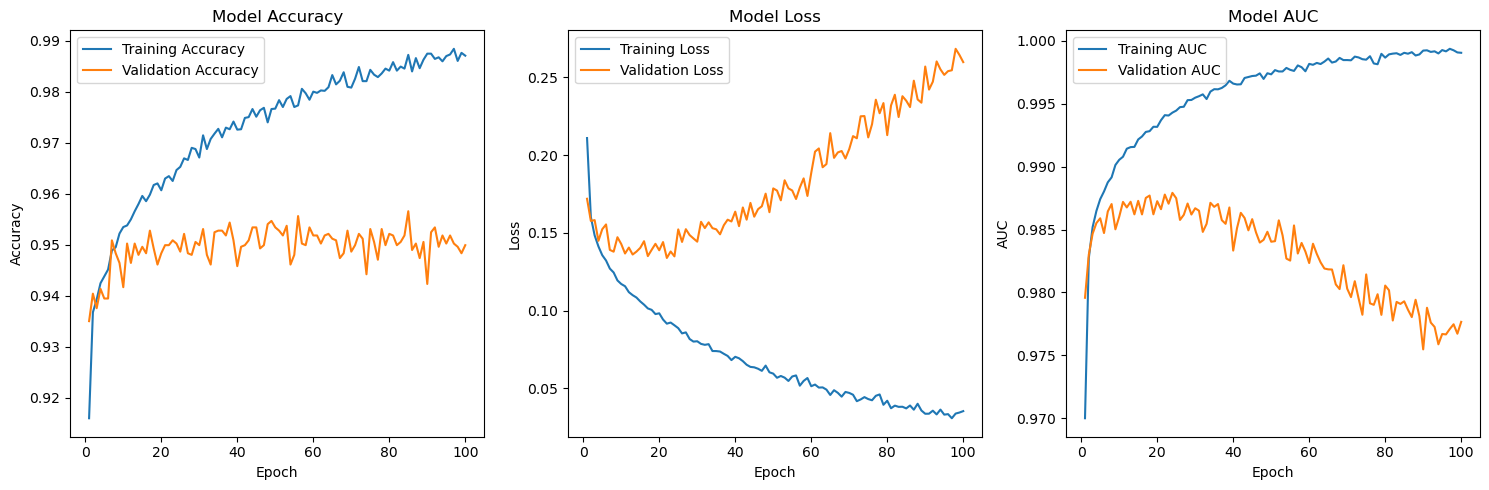

In [168]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index + 1

plt.figure(figsize=(15, 5))

# Model Accuracy
plt.subplot(1, 3, 1)
sns.lineplot(x='epoch', y='accuracy', data=history_df, label='Training Accuracy')
sns.lineplot(x='epoch', y='val_accuracy', data=history_df, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Model Loss
plt.subplot(1, 3, 2)
sns.lineplot(x='epoch', y='loss', data=history_df, label='Training Loss')
sns.lineplot(x='epoch', y='val_loss', data=history_df, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Model AUC
plt.subplot(1, 3, 3)
sns.lineplot(x='epoch', y='auc', data=history_df, label='Training AUC')
sns.lineplot(x='epoch', y='val_auc', data=history_df, label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

## Recursive feature elimination with Random forrest

**This code runs very long time**

In [1321]:
recall_scores = {}

In [ ]:
for n_features in range(1, X_train_scaled.shape[1] + 1):
    print(f"Selecting {n_features} features")
    
    # RFE with the model
    sel_ = RFE(RandomForestClassifier(n_estimators=200, random_state=0), n_features_to_select=n_features)
    sel_.fit(X_train_scaled, y_train)
    
    # Select the features
    selected_feat = X_train_scaled.columns[(sel_.get_support())]
    X_train_selected = X_train_scaled[selected_feat]
    X_test_selected = X_test_scaled[selected_feat]
    
    # Train the Random Forest model
    rf1 = RandomForestClassifier(n_estimators=200, random_state=0)
    rf1.fit(X_train_selected, y_train)
    
    # Predict and calculate recall score
    y_pred_test_rf_sel = rf1.predict(X_test_selected)
    recall_test_rf_selected = recall_score(y_test, y_pred_test_rf_sel)
    
    # Store the recall score and number of features in the dictionary
    recall_scores[n_features] = recall_test_rf_selected
    #print(f"Recall score for {n_features} features: {recall_test_rf_selected}")

In [ ]:
sns.lineplot(recall_scores)

In [ ]:
sorted_dict = dict(sorted(recall_scores.items(), key=lambda item: item[1], reverse=True))
next(iter(sorted_dict.items()))